# The Vanilla GAN

The imports and the Xavier Initialization should be quite familiar. This have been covered in previous notebooks.

In [1]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable

device = torch.device("cpu")
%matplotlib inline

mb_size = 64
Z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128
c = 0
lr = 1e-3

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    vec = torch.randn(*size) * xavier_stddev

    vec = vec.to(device)
    vec.requires_grad = True
    return vec

## Init the MNIST dataset
Again, I will be skipping the explanation for this so that we can move on to the more interesting stuff.

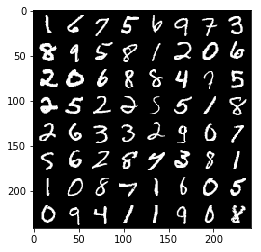

In [2]:
import torchvision
import torchvision.transforms as transforms
dataroot = '../Data'
# load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0,), (1,))])
trainset = torchvision.datasets.MNIST(root=dataroot , train=True,
                                        download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)

#########################
#You will insert the labels code (which I mentioned below) here code here. 
#########################
dataiter = iter(trainloader)
dataiter = iter(trainloader)
images, labels = dataiter.next()

def mnist_next(dataiter):

    try:
        images, labels = dataiter.next()
        images = images.view(images.numpy().shape[0],28*28)
    except:
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        images = images.view(images.numpy().shape[0],28*28)
    return images.numpy(), labels

def initialize_loader(trainset):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
    dataiter = iter(trainloader)
    return dataiter

images, labels = mnist_next(dataiter)
# print some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

## This is where it gets fun!
Let us now start defining our Genrator and Descriminator.
## Say you want to reuse the code, then all you have to do is change the weights ie. the architecture, of the NN below

# Generator

In [3]:
Wzh = xavier_init(size=[Z_dim, h_dim])
Whx = xavier_init(size=[h_dim, X_dim])
bzvar = torch.zeros(h_dim);
bhvar = torch.zeros(X_dim);
bzvar = bzvar.to(device)
bhvar = bhvar.to(device)
    
bzh = Variable(bzvar, requires_grad=True)
bhx = Variable(bhvar, requires_grad=True)

def G(z):
    h = nn.relu(torch.mm(z, Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(torch.mm(h, Whx) + bhx.repeat(h.size(0), 1))
    return X  




# Descriminator

In [4]:
Wxh = xavier_init(size=[X_dim, h_dim])
Why = xavier_init(size=[h_dim, 1])
bxvar = torch.zeros(h_dim)
bhvar = torch.zeros(1)

bxvar = bxvar.to(device)
bhvar = bhvar.to(device)
    
bxh = Variable(bxvar, requires_grad=True)
bhy = Variable(bhvar, requires_grad=True)

def D(X):
    h = nn.relu(torch.mm(X, Wxh) + bxh.repeat(X.size(0), 1))
    y = nn.sigmoid(torch.mm(h, Why) + bhy.repeat(h.size(0), 1))
    return y  

# Training

In [5]:
G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params


def reset_grad():
    for p in params:
        p.grad.data.zero_()


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = torch.ones(mb_size)
zeros_label = torch.zeros(mb_size)

ones_label = ones_label.to(device)
zeros_label = zeros_label.to(device)

## This is the last step of our training process

In [6]:
dataiter = initialize_loader(trainset)

for it in range(10000):
    # Sample data
    z = torch.randn(mb_size, Z_dim)
    X, _ = mnist_next(dataiter)
    if X.shape[0]!=mb_size:
        dataiter = initialize_loader(trainset)
        X,_ = mnist_next(dataiter)
    X = torch.from_numpy(X)
    
    X = X.to(device)
    z = z.to(device)
    
    # Dicriminator forward-loss-backward-update
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    
    z = torch.randn(mb_size, Z_dim)
    z=z.to(device)
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-',it,'; D_loss: ',D_loss.data.cpu().numpy(),'; G_loss: ', G_loss.data.cpu().numpy())

/Users/akshaydharmavaram/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Iter- 0 ; D_loss:  1.5804755687713623 ; G_loss:  2.0668246746063232
Iter- 1000 ; D_loss:  0.005401396658271551 ; G_loss:  7.96695613861084
Iter- 2000 ; D_loss:  0.039762645959854126 ; G_loss:  6.386065483093262
Iter- 3000 ; D_loss:  0.057999931275844574 ; G_loss:  4.620909214019775
Iter- 4000 ; D_loss:  0.12993550300598145 ; G_loss:  6.619591236114502
Iter- 5000 ; D_loss:  0.38045719265937805 ; G_loss:  4.303133010864258
Iter- 6000 ; D_loss:  0.41104763746261597 ; G_loss:  4.60413122177124
Iter- 7000 ; D_loss:  0.4613766670227051 ; G_loss:  2.955204486846924
Iter- 8000 ; D_loss:  0.8485115766525269 ; G_loss:  3.173837423324585
Iter- 9000 ; D_loss:  0.7267921566963196 ; G_loss:  2.468902111053467


## Now for just visualizing

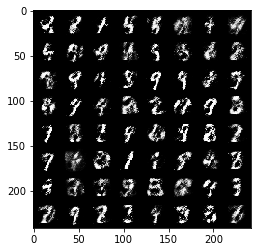

In [7]:
z = torch.randn(mb_size, Z_dim)
z = z.to(device)
samples = G(z)
samples = samples.cpu()
img = samples.data
img = img.view([64,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())

The below code is really cool and I advise you use it when you are working with GAN's. We can also make other even better interpolations using special non-linear interpolators like Disco GAN's. We will look into them shortly.

### Now, just simple interpolation code (Linear combination of two vectors) to convert between images

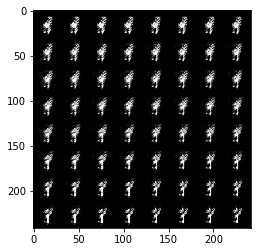

In [8]:
a = torch.randn( Z_dim);
b = torch.randn(Z_dim);
noise = torch.Tensor(mb_size,Z_dim)

line  = torch.linspace(0, 1, mb_size)

for i in range(0, mb_size):
    noise.select(0, i).copy_(a * line[i] + b * (1 - line[i]))

noise = noise.to(device)
samples = G(noise)

samples = samples.cpu()
img = samples.data
img = img.view([64,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())